In [1]:
import pandas as pd
import os
import sys
import torch
import pickle
from transformers import AutoTokenizer
from transformers import GPT2Tokenizer
from torch.nn import functional as F
import tqdm
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer
import scipy.stats as stats

In [2]:
# model_name_list = [
#     'out-babylm_full_bpe_8k-6x6-nomask-curr_log-6607670',
#     'out-babylm_full_bpe_8k-6x6-nomask-curr_log-6621801',
#     'out-babylm_full_bpe_8k-6x6-nomask-curr_lin-6620547',
#     'out-babylm_full_bpe_8k-6x6-nomask-curr_lin-6620548',
#     'out-babylm_full_bpe_8k-6x6-mask_-6617787',
#     'out-babylm_full_bpe_8k-6x6-mask_sig001-6486043',
#     'out-babylm_full_bpe_8k-6x6-mask_sig0p5-6486044',
#     
# ]

# model_name_list = ['out-babylm_full_bpe_8k-6x6-mask_ee004_em10-6683311',
#  'out-babylm_full_bpe_8k-6x6-mask_ee004_em05-6683310',
#  'out-babylm_full_bpe_8k-6x6-mask_ee003_em05-6683308',
#  'out-babylm_full_bpe_8k-6x6-mask_ee003_em10-6683309',
#  'out-babylm_full_bpe_8k-6x6-mask_log0p5_em10-6681951',
#  'out-babylm_full_bpe_8k-6x6-mask_log0p5_em05-6681950',
#  'out-babylm_full_bpe_8k-6x6-mask_log002_em10-6681949',
#  'out-babylm_full_bpe_8k-6x6-mask_log002_em10-6681948',
#  'out-babylm_full_bpe_8k-6x6-mask_log002_em05-6681947',
#  'out-babylm_full_bpe_8k-6x6-mask_ee0p5_em10-6681946',
#  'out-babylm_full_bpe_8k-6x6-mask_ee0p5_em05-6681945',
#  'out-babylm_full_bpe_8k-6x6-mask_ee002_em10-6681944',
#  'out-babylm_full_bpe_8k-6x6-mask_ee002_em05-6681942',
#  'out-babylm_full_bpe_8k-6x6-mask_lin_em10-6681941',
#  'out-babylm_full_bpe_8k-6x6-mask_log001_em10-6681940',
#  'out-babylm_full_bpe_8k-6x6-mask_ee001_em10-6681939',
#  'out-babylm_full_bpe_8k-6x6-mask_lin_em05-6681938',
#  'out-babylm_full_bpe_8k-6x6-mask_log001_em05-6681937',
#  'out-babylm_full_bpe_8k-6x6-mask_ee001_em05-6681922',
#  'out-babylm_full_bpe_8k-4x4-mask_e100-5988019',
#  'out-babylm_full_bpe_8k-8x8-nomask-5496426',
#  'out-babylm_full_bpe-6x6-nomask-5492134',
#  'out-babylm_full_bpe-8x8-nomask-5492054',
#  'out-babylm_wocdes_full_bpe-4x4-nomask-5445338',
#  'out-babylm_full_bpe-4x4-nomask-5444724']

# model_name_list = ['out-babylm_full_bpe_8k-6x6-mask_ee001_em01-6810203',
#  'out-babylm_full_bpe_8k-6x6-mask_log001_em01-6810205',
#  'out-babylm_full_bpe_8k-6x6-mask_ee002_em01-6810296',
#  'out-babylm_full_bpe_8k-6x6-mask_ee003_em01-6810297',
#  'out-babylm_full_bpe_8k-6x6-mask_log002_em01-6810320',
#  'out-babylm_full_bpe_8k-6x6-mask_ee0p5_em01-6810321',
#  'out-babylm_full_bpe_8k-6x6-mask_log0p5_em01-6810323',
#  'out-babylm_full_bpe_8k-6x6-mask_ee004_em01-6810325']

model_name_list = ['out-babylm_full_bpe_8k-6x6-mask_log001-6617787',
 'out-babylm_full_bpe_8k-6x6-nomask-curr_log-7047459_s42',
 'out-babylm_full_bpe_8k-6x6-nomask-curr_log-7047460_s2347',
 'out-babylm_full_bpe_8k-6x6-nomask-curr_log-7047461_s9',
 'out-babylm_full_bpe_8k-6x6-nomask-curr_log-7047462_s616',
 'out-babylm_full_bpe_8k-6x6-nomask-curr_log-7047464_s46674',
 'out-babylm_full_bpe_8k-6x6-nomask-curr_log-7047466_s6747',
 'out-babylm_full_bpe_8k-6x6-nomask-curr_log-7047467_s869',
 'out-babylm_full_bpe_8k-6x6-nomask-curr_log-7047468_s466',
 'out-babylm_full_bpe_8k-6x6-nomask-curr_log-7047469_s11111']

tokenizers_root = r"/home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/data"
out_root = r'/home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/output_dump'

data_folder = r'babylm_full_bpe_8k'
model_name = 'out-babylm_full_bpe_8k-6x6-mask_lin-5734459_s1337'

#model_name = model_list[0]

out_dir = os.path.join(out_root, model_name)
data_dir = os.path.join(tokenizers_root, data_folder)

device = "cuda"

In [22]:
def load_model(out_dir, device):
    """
    Loads a pre-trained GPT model from a checkpoint file.

    Args:
        out_dir (str): The directory where the checkpoint file is located.
        device (torch.device): The device to load the model onto.

    Returns:
        GPT: The loaded GPT model.

    Raises:
        FileNotFoundError: If the checkpoint file is not found.
    """
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    print(f"Loading model from {ckpt_path}")
    #NANOGPT_ROOT = str(Path(__file__).parents[4])
    NANOGPT_ROOT = r'/home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT' #Edit later to be dynamic
    sys.path.append(NANOGPT_ROOT)
    from model import GPT, GPTConfig

    checkpoint = torch.load(ckpt_path, map_location=device)

    # Backward compatibility for new model args for QKV and FFW Adjustments
    if checkpoint["model_args"].get("wm_decay_length", None) is None:
        #wm_decay_length = block_size
        checkpoint["model_args"]["wm_decay_length"] = checkpoint["model_args"]["block_size"]
    # Setting head size as 3 times n_embd if not set already
    if checkpoint['model_args'].get('head_size_qkv', None) is None:
        checkpoint['model_args']['head_size_qkv'] = checkpoint['model_args']['n_embd']

    if checkpoint["model_args"].get("ffw_dim", None) is None:
        checkpoint["model_args"]["ffw_dim"] = 4 * checkpoint["model_args"]["n_embd"]

    #print(checkpoint['model_args'])
    gptconf = GPTConfig(**checkpoint['model_args'])

    load_model = GPT(gptconf)

    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k, v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)

    load_model.load_state_dict(state_dict)
    load_model.eval()

    load_model = load_model.to(device)

    return load_model

def load_tokenizer(data_dir):
    """
    Load tokenizer for natural stories evaluation.

    Args:
        data_dir (str): The directory path where the tokenizer data is stored.

    Returns:
        tokenizer (Tokenizer): The loaded tokenizer object.

    Raises:
        NotImplementedError: If stoi/itos is not supported or found.

    """
    meta_path = os.path.join(data_dir, 'meta.pkl')
    load_meta = os.path.exists(meta_path)
    if load_meta:
        with open(meta_path, 'rb') as f:
            meta = pickle.load(f)
        if meta.get("custom_tokenizer", False):
            print(f"Loading custom tokenizer from {data_dir}")
            tokenizer = AutoTokenizer.from_pretrained(data_dir, use_fast=False)
        else:
            if meta.get("stoi", False):
                raise NotImplementedError("stoi/itos not supported yet")
            else:
                raise NotImplementedError("No stoi/itos found")
    else:
        print("No meta.pkl found, using default GPT-2 tokenizer")
        tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")

    if not tokenizer.eos_token:
        tokenizer.add_special_tokens({"eos_token": "</s>"})
    if not tokenizer.pad_token:
        tokenizer.pad_token = tokenizer.eos_token

    tokenizer.padding_side = "left" #Add if needed?
    return tokenizer

def load_model_tokenizer(out_dir, data_dir, device):
    model = load_model(out_dir, device)
    tokenizer = load_tokenizer(data_dir)
    return model, tokenizer

def load_RT_data(rt_root=r'naturalstories_RTS'):
    """
    Load the processed RT data from the RT_root directory
    :param rt_root: 
    :return: processsed_RTs, processed_wordinfo, all_stories, where processed RTs are at WorkerId level ...(fill) 
    """
    
    pr_RTs = pd.read_csv(os.path.join(rt_root,'processed_RTs.tsv'), sep='\t')
    #column Item represents the story number, zone is word analogue to word number in the story. Sort by Item and Zone to get the word order in the story
    pr_RTs = pr_RTs.sort_values(by=['item', 'WorkerId', 'zone'])
    
    pr_wi = pd.read_csv(os.path.join(rt_root,'processed_wordinfo.tsv'), sep='\t')
    pr_wi = pr_wi.sort_values(by=['item', 'zone'])
    
    all_st = pd.read_csv(os.path.join(rt_root,'all_stories.tok'), sep='\t')
    all_st = all_st.sort_values(by=['item', 'zone'])
    
    return pr_RTs, pr_wi, all_st

def extract_stories_from_df(stories_df):
    """
    Extract stories from the dataframe with id as key and story as value
    :param stories_df: 
    :return: stories: Dictionary with story id as key and story as value
    """
    stories = {}
    story_ids = stories_df["item"].unique()
    for story_id in story_ids:
        story = stories_df[stories_df["item"] == story_id]
        story_text = story.sort_values(by=['zone'])['word'].str.cat(sep=' ')
        stories[story_id] = story_text

    return stories

def tokenize_story(story, tokenizer):
    """
    Tokenize the story using the tokenizer
    :param story: -> str 
    :param tokenizer: -> tokenizer 
    :return: tokenized_story -> tensor
    """
    tokenized_story = tokenizer.encode(story, return_tensors='pt')
    #since passing only one story, remove the batch dimension
    tokenized_story = tokenized_story.squeeze()
    return tokenized_story

def multitoken_wordmap(token_list, story_id, story_df, tokenizer):
    """
    Create a mapping of words to tokens for a given story because 1 word can be multiple tokens
    :param token_list: 
    :param story_id: 
    :param story_df: 
    :param tokenizer: 
    :return: token_map: List of dictionaries with word, zone, tokens, item
    """
    word_list = story_df[story_df['item'] == story_id][['word', 'zone']].to_dict('records')
    word_list = sorted(word_list, key=lambda x: x['zone'])

    token_map = []
    token_index = 0
    for i, word_row in enumerate(word_list):
        word = word_row['word']
        zone = word_row['zone']
        #since 1 word can be multiple tokens, we need to keep track of the tokens that make up the word
        decode_list = []
        while True:
            if token_index >= len(token_list):
                break
            decode_list.append(token_list[token_index].item())
            decoded_words = tokenizer.decode(decode_list).strip()
            token_index += 1
            if word.lower() == decoded_words:
                break

        token_map.append({"item": story_id, "zone": zone, "word": word, "tokens": decode_list})
    return token_map

def return_surprisals(model, token_list):
    if len(token_list)>model.config.block_size:
        token_list = token_list[-model.config.block_size:]
        #print size of token_list? Shouldn't it be 1+block_size?
        #Or...
        
    token_tensor = torch.tensor(token_list).unsqueeze(0).to(device)
    with torch.no_grad():
        logits, _ = model(token_tensor[:, :-1], token_tensor[:, 1:])
    probs = F.log_softmax(logits, dim=-1)
    token_logprob = probs[0, -1, token_tensor[0, -1]].item()
    return -token_logprob

def get_model_surprisals(model, tokenized_story_df, story_id, tokenizer):
    tokenized_story = tokenized_story_df[tokenized_story_df['item'] == story_id].to_dict('records')
    tokenized_story = sorted(tokenized_story, key=lambda x: x['zone'])
    #Prepend the bos token
    logits_input_list = [tokenizer.bos_token_id]

    for word_row in tqdm.tqdm(tokenized_story, leave=False):
        tokens = word_row['tokens']
        if len(tokens) == 1:
            logits_input_list.append(tokens[0])
            word_surprisal = return_surprisals(model, logits_input_list)
        else:
            word_surprisal = 0
            for token in tokens:
                logits_input_list.append(token)
                word_surprisal += return_surprisals(model, logits_input_list)

        word_row['surprisal'] = word_surprisal

    return tokenized_story


def return_surprisals(model, token_list):
    if len(token_list)>model.config.block_size:
        token_list = token_list[-model.config.block_size:]
    token_tensor = torch.tensor(token_list).unsqueeze(0).to(device)
    with torch.no_grad():
        logits, _ = model(token_tensor[:, :-1], token_tensor[:, 1:])
    probs = F.log_softmax(logits, dim=-1)
    token_logprob = probs[0, -1, token_tensor[0, -1]].item()
    return -token_logprob

def get_model_surprisals(model, tokenized_story_df, story_id, tokenizer):
    tokenized_story = tokenized_story_df[tokenized_story_df['item'] == story_id].to_dict('records')
    tokenized_story = sorted(tokenized_story, key=lambda x: x['zone'])
    #Prepend the bos token
    logits_input_list = [tokenizer.bos_token_id]

    for word_row in tqdm.tqdm(tokenized_story):
        tokens = word_row['tokens']
        if len(tokens) == 1:
            logits_input_list.append(tokens[0])
            word_surprisal = return_surprisals(model, logits_input_list)
        else:
            word_surprisal = 0
            for token in tokens:
                logits_input_list.append(token)
                word_surprisal += return_surprisals(model, logits_input_list)

        word_row['surprisal'] = word_surprisal

    return tokenized_story

def build_linear_model_kfold(data_df, x_type = "surprisal", per_subject=False, subject_id=None):
    """
    Build a kfold crossvalidation linear model to predict RTs from surprisals

    Assuming data_df is the right df being passed. If per subject, it needs to be processed_RTs, else processed_wordinfo
    :param data_df: Dataframe containing the RTs and surprisals, if per_subject is True, then the dataframe should contain WorkerId.
    :param x_type: Choice between only surprisal, or 1 lag or 2 lag, can be surprisal, lag 1, lag 2
    :param per_subject: If True, then the model will be built per subject. If False, then the model will be built for all subjects, on mean RTs
    :param subject_id: If per_subject is True, then the subject_id should be provided to build the model for that subject
    :return: regr: The linear regression model, mse: Mean squared error, r2: R squared value, X_train, X_test, y_train, y_test
    :return:
    """

    if per_subject:
        if subject_id is None:
            raise ValueError("subject_id should be provided if per_subject is True")
        data_df = data_df[data_df['WorkerId'] == subject_id]

    if x_type == "surprisal":
        X = data_df[['surprisal']].to_numpy()
    elif x_type == "lag 1":
        X = data_df[["surprisal", 'surprisal_lag_1']].to_numpy()
    elif x_type == "lag 2":
        X = data_df[['surprisal', 'surprisal_lag_1', 'surprisal_lag_2']].to_numpy()
    else:
        raise ValueError("Invalid x_type, should be surprisal, lag 1 or lag 2")

    if per_subject:
        y = data_df['RT'].to_numpy()
    else:
        y = data_df['meanItemRT'].to_numpy() #assuming the right df is passed

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    def custom_correlation_coeff_scorer(y_true, y_pred):
        return np.corrcoef(y_true, y_pred)[0][1]
    #print("X_train shape, X_test shape, y_train shape, y_test shape", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    regr = linear_model.LinearRegression()
    #regr.fit(X_train, y_train)
    scores = cross_validate(regr, X, y, cv=5, scoring={'r2': 'r2', 
                                                       'neg_mean_squared_error': 'neg_mean_squared_error', 
                                                       'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                                                       "explained_variance": "explained_variance",
                                                       "custom_correlation_coeff_scorer": make_scorer(custom_correlation_coeff_scorer)}, 
                            return_train_score=True)    
    return scores

def all_subject_summary_kfold(processed_RTs, x_type="lag 2"):

    subject_id_list = processed_RTs['WorkerId'].unique()
    subject_summary = []
    
    for subject_id in tqdm.tqdm(subject_id_list):

        #ignore the subject if the number of data points is less than 1000 (assuming 1 story has atleast 1000 data points)

        if len(processed_RTs[processed_RTs['WorkerId'] == subject_id]) < 1000:
            continue

        scores = build_linear_model_kfold(processed_RTs, x_type=x_type, per_subject=True, subject_id=subject_id)
        
        subject_summary.append({"subject_id": subject_id,
                                "data_points": len(processed_RTs[processed_RTs['WorkerId'] == subject_id]),
                                "mse_surprisal": -1*np.mean(scores['test_neg_mean_squared_error']),   
                                "rmse_surprisal": -1*np.mean(scores['test_neg_root_mean_squared_error']),
                                "r2_surprisal": np.mean(scores['test_r2']),
                                "explained_variance": np.mean(scores['test_explained_variance']),
                                "corr_surprisal": np.mean(scores['test_custom_correlation_coeff_scorer'])})
        

    return pd.DataFrame(subject_summary)


def calculate_surprisal_statistics(model_name, dataset):
    out_dir = os.path.join(out_root, model_name)
    data_dir = os.path.join(tokenizers_root, dataset)
    model, tokenizer = load_model_tokenizer(out_dir, data_dir, device)
    processed_RTs, processed_wordinfo, all_stories = load_RT_data(rt_root=r'naturalstories_RTS')
    stories = extract_stories_from_df(all_stories)
    
    token_map_df = pd.DataFrame()
    for i, story in stories.items():
        tokenized_story_i = tokenize_story(story, tokenizer)
        token_map = multitoken_wordmap(tokenized_story_i, i, processed_wordinfo, tokenizer)
        token_map_df = pd.concat([token_map_df, pd.DataFrame(token_map)])
    
    story_surprisals_df = pd.DataFrame()
    for i, story in stories.items():
        #print(f"Processing story {i}")
        story_surprisals = get_model_surprisals(model, token_map_df, i, tokenizer)
        story_surprisals_df = pd.concat([story_surprisals_df, pd.DataFrame(story_surprisals)])

        
    #Join the surprisals with the original wordinfo and RTs
    processed_RTs = processed_RTs.merge(story_surprisals_df, on=['item', 'zone', 'word'], how='left')
    
    processed_wordinfo = processed_wordinfo.merge(story_surprisals_df, on=['item', 'zone', 'word'], how='left')
    
    #Add addition columns for the surprisals of the previous 2 words but for in each worker, story separately
    processed_RTs['surprisal_lag_1'] = processed_RTs.groupby(['item', 'WorkerId'])['surprisal'].shift(1)
    processed_RTs['surprisal_lag_2'] = processed_RTs.groupby(['item', 'WorkerId'])['surprisal'].shift(2)
    
    processed_wordinfo['surprisal_lag_1'] = processed_wordinfo.groupby(['item'])['surprisal'].shift(1)
    processed_wordinfo['surprisal_lag_2'] = processed_wordinfo.groupby(['item'])['surprisal'].shift(2)
    
    #Fill the missing values with the mean surprisal of the word
    processed_RTs["surprisal_lag_1"] = processed_RTs['surprisal_lag_1'].fillna(processed_RTs.groupby(['item'])['surprisal'].transform('mean'))
    processed_RTs['surprisal_lag_2'] = processed_RTs['surprisal_lag_2'].fillna(processed_RTs.groupby(['item'])['surprisal'].transform('mean'))
    
    processed_wordinfo["surprisal_lag_1"] = processed_wordinfo['surprisal_lag_1'].fillna(processed_RTs.groupby(['item'])['surprisal'].transform('mean'))
    processed_wordinfo['surprisal_lag_2'] = processed_wordinfo['surprisal_lag_2'].fillna(processed_RTs.groupby(['item'])['surprisal'].transform('mean'))
    
    
    scores_df = all_subject_summary_kfold(processed_RTs, x_type="lag 2")
    
    return scores_df
    

Processing model out-babylm_full_bpe_8k-6x6-mask_log001-6617787, with dataset babylm_full_bpe_8k
Processing model out-babylm_full_bpe_8k-6x6-mask_log001-6617787, with dataset babylm_full_bpe_8k, H1223
Loading model from /home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/output_dump/out-babylm_full_bpe_8k-6x6-mask_log001-6617787/ckpt.pt
Error processing model out-babylm_full_bpe_8k-6x6-mask_log001-6617787, with dataset babylm_full_bpe_8k
[Errno 2] No such file or directory: '/home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/output_dump/out-babylm_full_bpe_8k-6x6-mask_log001-6617787/ckpt.pt'
Model out-babylm_full_bpe_8k-6x6-nomask-curr_log-7047459_s42 already processed, skipping
side track for model 7047459 for a bit
Processing model out-babylm_full_bpe_8k-6x6-nomask-curr_log-7047459_s42, with dataset babylm_full_bpe_8k, H1223
Loading model from /home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/output_dump/out-babylm_full_bpe_8k-6x6-nomask-c

100%|██████████| 180/180 [00:29<00:00,  6.17it/s]


         subject_id  data_points  mse_surprisal  rmse_surprisal  r2_surprisal  \
0    A117RW2F1MNBQ8         5198   11791.147086      102.896273     -1.376686   
1    A11AUVZ4MCA7VU        10224   30289.140159      173.319060      0.018657   
2    A11GA4B4SEYK44         4211   11208.821586       97.416675     -0.062500   
3    A11KMPAZSE5Q0Q         5199    3957.362864       62.118941     -0.044351   
4    A127R5QI5OGBIK         5194   18353.490239      132.975285     -0.740942   
..              ...          ...            ...             ...           ...   
159   ASOBUAZ0IQYSJ         4115   26525.280710      159.103186     -0.021009   
160   AVG2BI8CS5YKX         5033   15874.918765      124.226814     -0.328341   
161   AWMGC78CSF6YL         3958   18040.863943      131.350169      0.013034   
162   AWZ3AH7JH0DRO         5033   34804.550761      180.725401     -0.090879   
163  A3AA8NU3WAJ3ED         2266   25117.729252      157.566817     -0.340803   

     explained_variance  co

,model1,model2,t_stat,p_val
0,out-babylm_full_bpe_8k-6x6-mask_lin-5734459_s1337,out-babylm_full_bpe_8k-6x6-mask_e250-5734550,5.073916,1.051875e-06
1,out-babylm_full_bpe_8k-6x6-mask_lin-5734459_s1337,out-babylm_full_bpe_8k-6x6-nomask-5496427,3.435423,7.505357e-04
2,out-babylm_full_bpe_8k-6x6-mask_lin-5734459_s1337,out-babylm_full_bpe_8k-6x6-nomask-curr_log-660...,4.974441,1.647342e-06
3,out-babylm_full_bpe_8k-6x6-mask_lin-5734459_s1337,out-babylm_full_bpe_8k-6x6-nomask-curr_log-662...,3.025511,2.885053e-03
4,out-babylm_full_bpe_8k-6x6-mask_lin-5734459_s1337,out-babylm_full_bpe_8k-6x6-nomask-curr_lin-662...,1.870899,6.315153e-02
...,...,...,...,...
9586,out-babylm_full_bpe_8k-6x6-nomask-curr_log-704...,out-babylm_full_bpe_8k-6x6-nomask-curr_log-704...,5.419629,2.115363e-07
9587,out-babylm_full_bpe_8k-6x6-nomask-curr_log-704...,out-babylm_full_bpe_8k-6x6-nomask-curr_log-704...,0.447679,6.549791e-01
9588,out-babylm_full_bpe_8k-6x6-nomask-curr_log-704...,out-babylm_full_bpe_8k-6x6-nomask-curr_log-704...,4.650488,6.808773e-06
9589,out-babylm_full_bpe_8k-6x6-nomask-curr_log-704...,out-babylm_full_bpe_8k-6x6-nomask-curr_log-704...,-1.614170,1.084248e-01


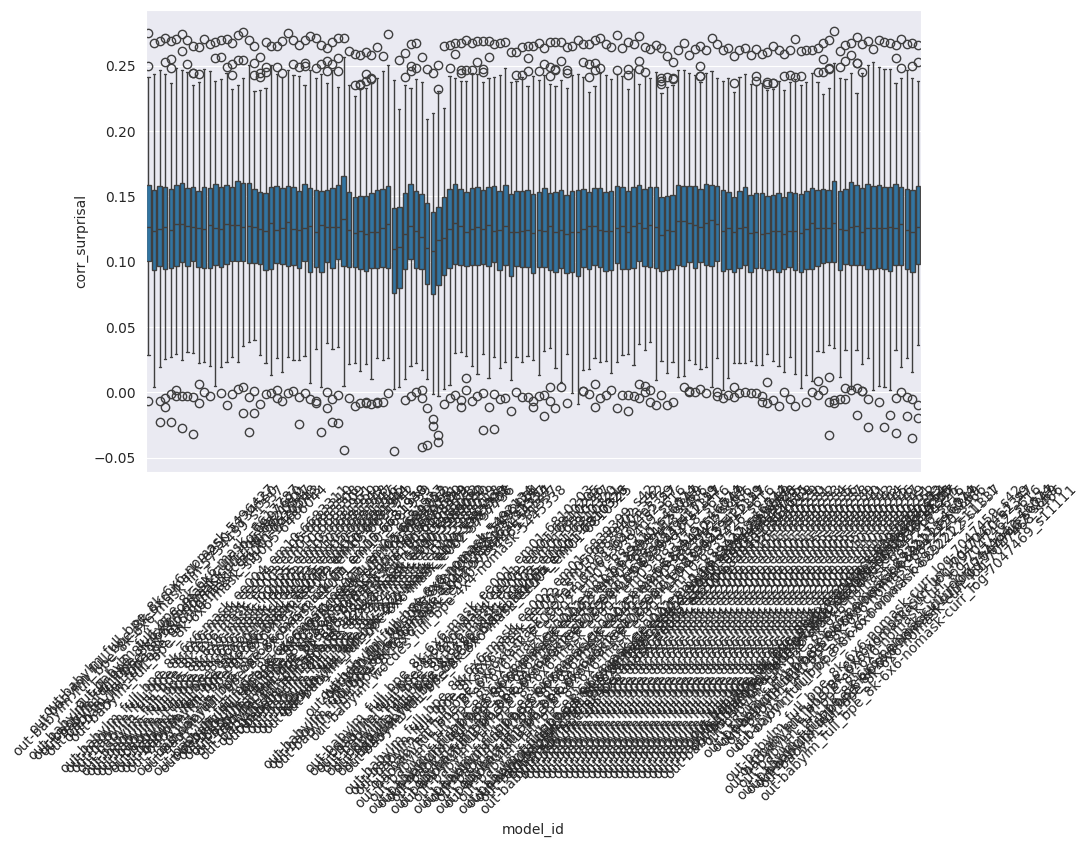

In [23]:
#Model comparison for multiple models 

# model_list = {
#     'out-babylm_full_bpe_8k-6x6-mask_lin-5734459_s1337':'babylm_full_bpe_8k',
#     "out-babylm_full_bpe_8k-6x6-mask_e250-5734550": "babylm_full_bpe_8k",
#     "out-babylm_full_bpe_8k-6x6-nomask-5496427": "babylm_full_bpe_8k",
# }
model_list = {x:"babylm_full_bpe_8k" for x in model_name_list}

for model_id, dataset in model_list.items():
    
    #Check if the model has already been processed and skip if it has
    processed_models_df = pd.read_csv("modelcomp_scores.csv", sep='\t')
    if model_id in processed_models_df['model_id'].values:
        print(f"Model {model_id} already processed, skipping")
        continue
    else:
        print(f"Processing model {model_id}, with dataset {dataset}")
        try:
            scores_df = calculate_surprisal_statistics(model_id, dataset)
        except Exception as e:
            print(f"Error processing model {model_id}, with dataset {dataset}")
            print(e)
            continue
        scores_df["model_id"] = model_id
        scores_df["dataset"] = dataset
        
        #append to processed_models_df
        processed_models_df = pd.concat([processed_models_df, scores_df])
        processed_models_df.to_csv("modelcomp_scores.csv", sep='\t', index=False)

#Calculate pairwise t-test for all models in the modelcomp_scores.csv
def paired_ttest_models(modelcomp_scores_df):
    model_ids = modelcomp_scores_df['model_id'].unique()
    model_pairs = []
    for i in range(len(model_ids)):
        for j in range(i+1, len(model_ids)):
            model1 = model_ids[i]
            model2 = model_ids[j]
            scores_df = modelcomp_scores_df[modelcomp_scores_df['model_id'] == model1]
            scores_df2 = modelcomp_scores_df[modelcomp_scores_df['model_id'] == model2]
            t_stat, p_val = stats.ttest_rel(scores_df['corr_surprisal'], scores_df2['corr_surprisal'])
            model_pairs.append({"model1": model1, "model2": model2, "t_stat": t_stat, "p_val": p_val})
    
    return pd.DataFrame(model_pairs)

ttest_df = paired_ttest_models(processed_models_df)
display(ttest_df)
#plot boxplot for the models
import seaborn as sns
def plot_boxplot_models(modelcomp_scores_df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='model_id', y='corr_surprisal', data=modelcomp_scores_df)
    plt.xticks(rotation=45)
    plt.show()
    
plot_boxplot_models(processed_models_df)
    

In [17]:
processed_models_df.groupby('model_id').mean("corr_surprisal")

,data_points,mse_surprisal,rmse_surprisal,r2_surprisal,explained_variance,corr_surprisal
model_id,,,,,,
out-babylm_full_bpe_8k-6x6-mask_-6617787,5141.103659,24020.900969,141.110997,-0.144218,0.014172,0.128184
out-babylm_full_bpe_8k-6x6-mask_e250-5734550,5141.103659,24037.674930,141.149085,-0.144616,0.013380,0.125343
out-babylm_full_bpe_8k-6x6-mask_lin-5734459_s1337,5141.103659,24017.700534,141.092153,-0.143871,0.014565,0.129568
out-babylm_full_bpe_8k-6x6-mask_sig001-6486043,5141.103659,24025.936089,141.121816,-0.144250,0.014013,0.126956
out-babylm_full_bpe_8k-6x6-mask_sig0p5-6486044,5141.103659,24034.919608,141.136890,-0.144269,0.013906,0.126084
out-babylm_full_bpe_8k-6x6-nomask-5496427,5141.103659,24022.146769,141.106741,-0.143883,0.014100,0.127439
out-babylm_full_bpe_8k-6x6-nomask-curr_lin-6620547,5141.103659,24008.558271,141.047615,-0.142396,0.014450,0.128143
out-babylm_full_bpe_8k-6x6-nomask-curr_lin-6620548,5141.103659,23994.265573,141.008849,-0.141837,0.014842,0.130027
out-babylm_full_bpe_8k-6x6-nomask-curr_log-6607670,5141.103659,24019.397556,141.098560,-0.143627,0.013979,0.126136
